# ML2 Final Project- Eugene Kim

In [50]:
"""
fake_vs_real_cnn.py
End-to-end, memory-safe baseline for classifying *real* vs. *fake* images.

Folder layout (relative to this file):
data/
 ├── train/  ├── real/  └── fake/
 ├── valid/  ├── real/  └── fake/
 └── test/   ├── real/  └── fake/
"""

import tensorflow as tf
from tensorflow.keras import layers, models
from pathlib import Path
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random


# ──────────────── CONFIG ────────────────
DATA_DIR   = Path("data")     
IMG_SIZE   = (160, 160)
BATCH_SIZE = 32
EPOCHS     = 30               
SEED       = 42
USE_FP16   = True             

In [37]:
# ──────────────── DATASETS ────────────────
def load_split(split: str, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_DIR / split,
        labels="inferred",
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED,
        validation_split=None,
        class_names=["real", "fake"]
    )
    total_images = len(ds) * BATCH_SIZE
    print(f"{split} dataset: {len(ds)} batches, {total_images} images")
    return ds

train_ds = load_split("train")
val_ds   = load_split("valid")
test_ds  = load_split("test", shuffle=False)

AUTOTUNE  = tf.data.AUTOTUNE
train_ds  = train_ds.cache().shuffle(1024).prefetch(AUTOTUNE)
val_ds    = val_ds.prefetch(AUTOTUNE)
test_ds   = test_ds.prefetch(AUTOTUNE)

# Print total images across all splits
total_train = len(train_ds) * BATCH_SIZE
total_valid = len(val_ds) * BATCH_SIZE
total_test = len(test_ds) * BATCH_SIZE
total_all = total_train + total_valid + total_test

print("\nTotal images:")
print(f"Train: {total_train:,}")
print(f"Valid: {total_valid:,}")
print(f"Test:  {total_test:,}")
print(f"Total: {total_all:,}")



Found 100000 files belonging to 2 classes.
train dataset: 3125 batches, 100000 images
Found 20000 files belonging to 2 classes.
valid dataset: 625 batches, 20000 images
Found 20000 files belonging to 2 classes.
test dataset: 625 batches, 20000 images

Total images:
Train: 100,000
Valid: 20,000
Test:  20,000
Total: 140,000


2025-05-30 20:06:04.584644: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


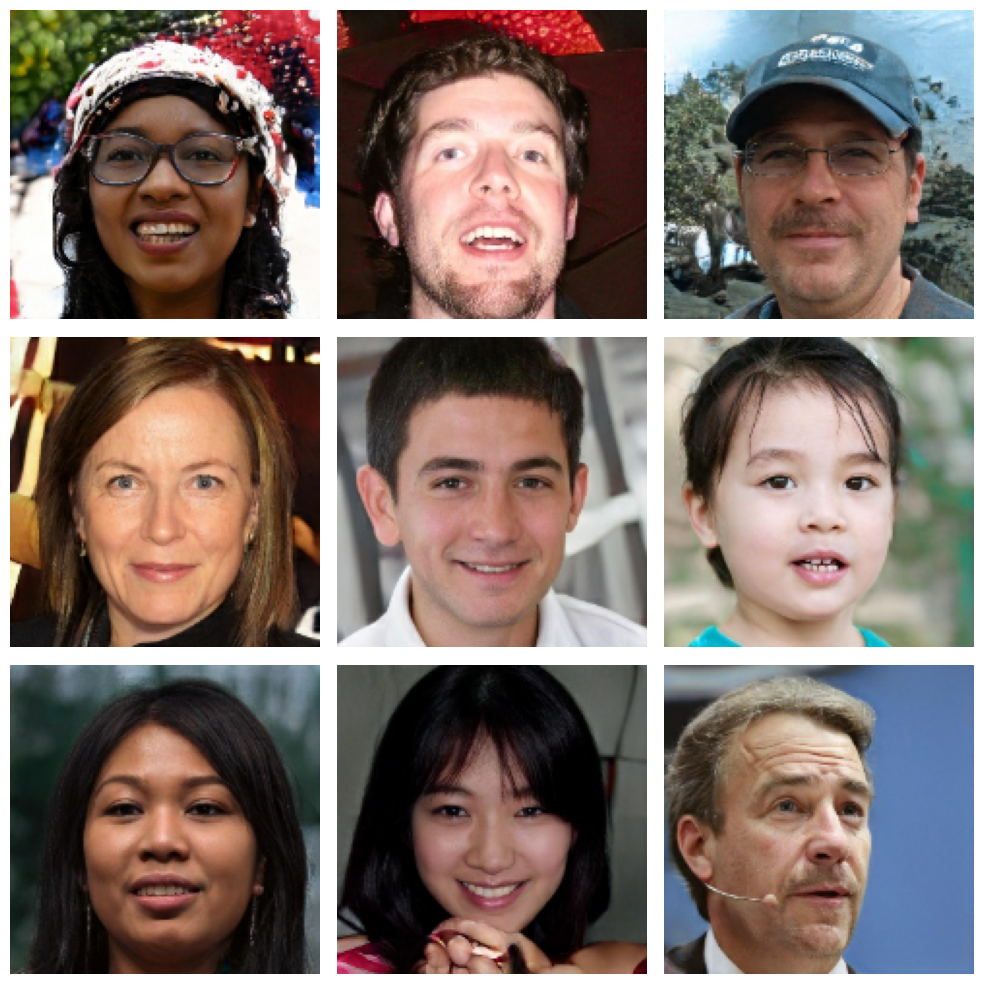

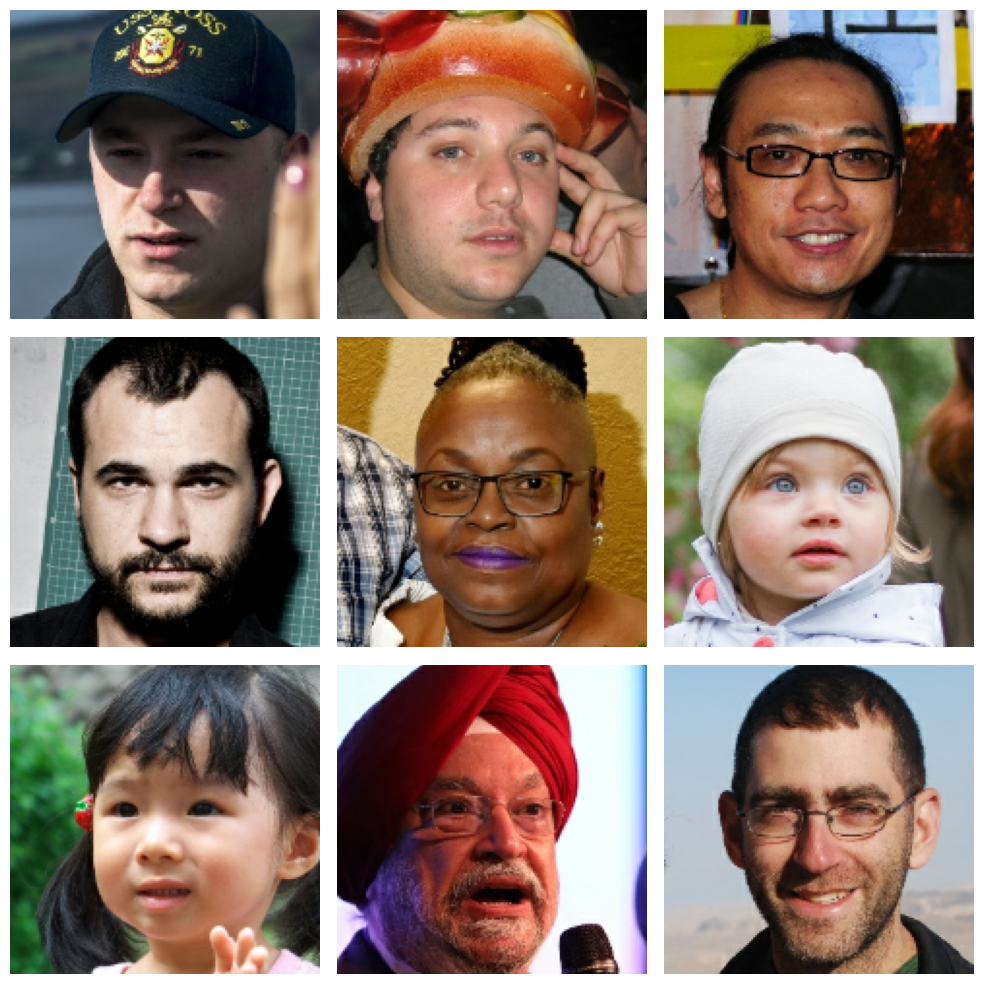

2025-05-30 20:06:05.827178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [99]:
# Plot real and fake images (3x3 grid)
plt.figure(figsize=(10, 10))

# Get a batch of images from the dataset
for images, labels in train_ds.take(1):
    # Convert labels to numpy array for boolean indexing
    labels_np = labels.numpy().flatten()  # Flatten labels to match image batch dimension
    real_images = images[labels_np == 1]  # Filter for real images (label=1)
    fake_images = images[labels_np == 0]  # Filter for fake images (label=0)
    
    # Randomly select 9 images from each category
    real_indices = np.random.choice(len(real_images), size=min(9, len(real_images)), replace=False)
    fake_indices = np.random.choice(len(fake_images), size=min(9, len(fake_images)), replace=False)
    
    # Convert indices to tensors and use tf.gather
    real_indices_tensor = tf.convert_to_tensor(real_indices, dtype=tf.int32)
    fake_indices_tensor = tf.convert_to_tensor(fake_indices, dtype=tf.int32)
    real_images = tf.gather(real_images, real_indices_tensor)
    fake_images = tf.gather(fake_images, fake_indices_tensor)
    
    # Plot real images
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            if idx < len(real_images):
                plt.subplot(3, 3, idx + 1)
                img = real_images[idx].numpy()
                img = (img - img.min()) / (img.max() - img.min())
                plt.imshow(img)
                plt.axis("off")
              
    plt.tight_layout()
    plt.show()
    
    # Plot fake images
    plt.figure(figsize=(10, 10))
  
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            if idx < len(fake_images):
                plt.subplot(3, 3, idx + 1)
                img = fake_images[idx].numpy()
                img = (img - img.min()) / (img.max() - img.min())
                plt.imshow(img)
                plt.axis("off")
            
  
    plt.tight_layout()
    plt.show()


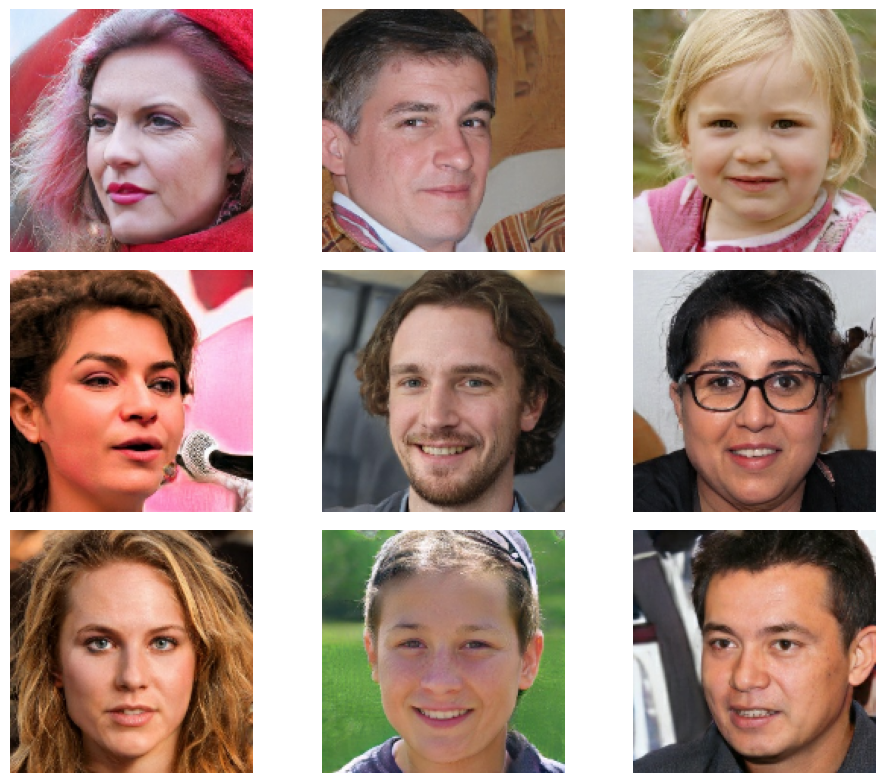

In [57]:
# Plot fake images (3x3 grid)
# Take random 9 of each
fake_images = random.sample(fake_images, min(9, len(fake_images)))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        if idx < len(fake_images):
            plt.subplot(3, 3, idx + 1)  # Use same indexing as real images
            plt.imshow(fake_images[idx])
            plt.axis("off")
plt.tight_layout()
plt.show()

Analyzing: 100%|██████████| 140000/140000 [04:12<00:00, 555.25it/s]



Class Balance:
label   fake   real
split              
test   10000  10000
train  50000  50000
valid  10000  10000

Resolution Statistics:
         width                                                  height         \
         count   mean  std    min    25%    50%    75%    max    count   mean   
label                                                                           
fake   70000.0  256.0  0.0  256.0  256.0  256.0  256.0  256.0  70000.0  256.0   
real   70000.0  256.0  0.0  256.0  256.0  256.0  256.0  256.0  70000.0  256.0   

                                               
       std    min    25%    50%    75%    max  
label                                          
fake   0.0  256.0  256.0  256.0  256.0  256.0  
real   0.0  256.0  256.0  256.0  256.0  256.0  

RGB Channel Statistics:
        r_mean                                                       \
         count       mean        std       min        25%       50%   
label                                          

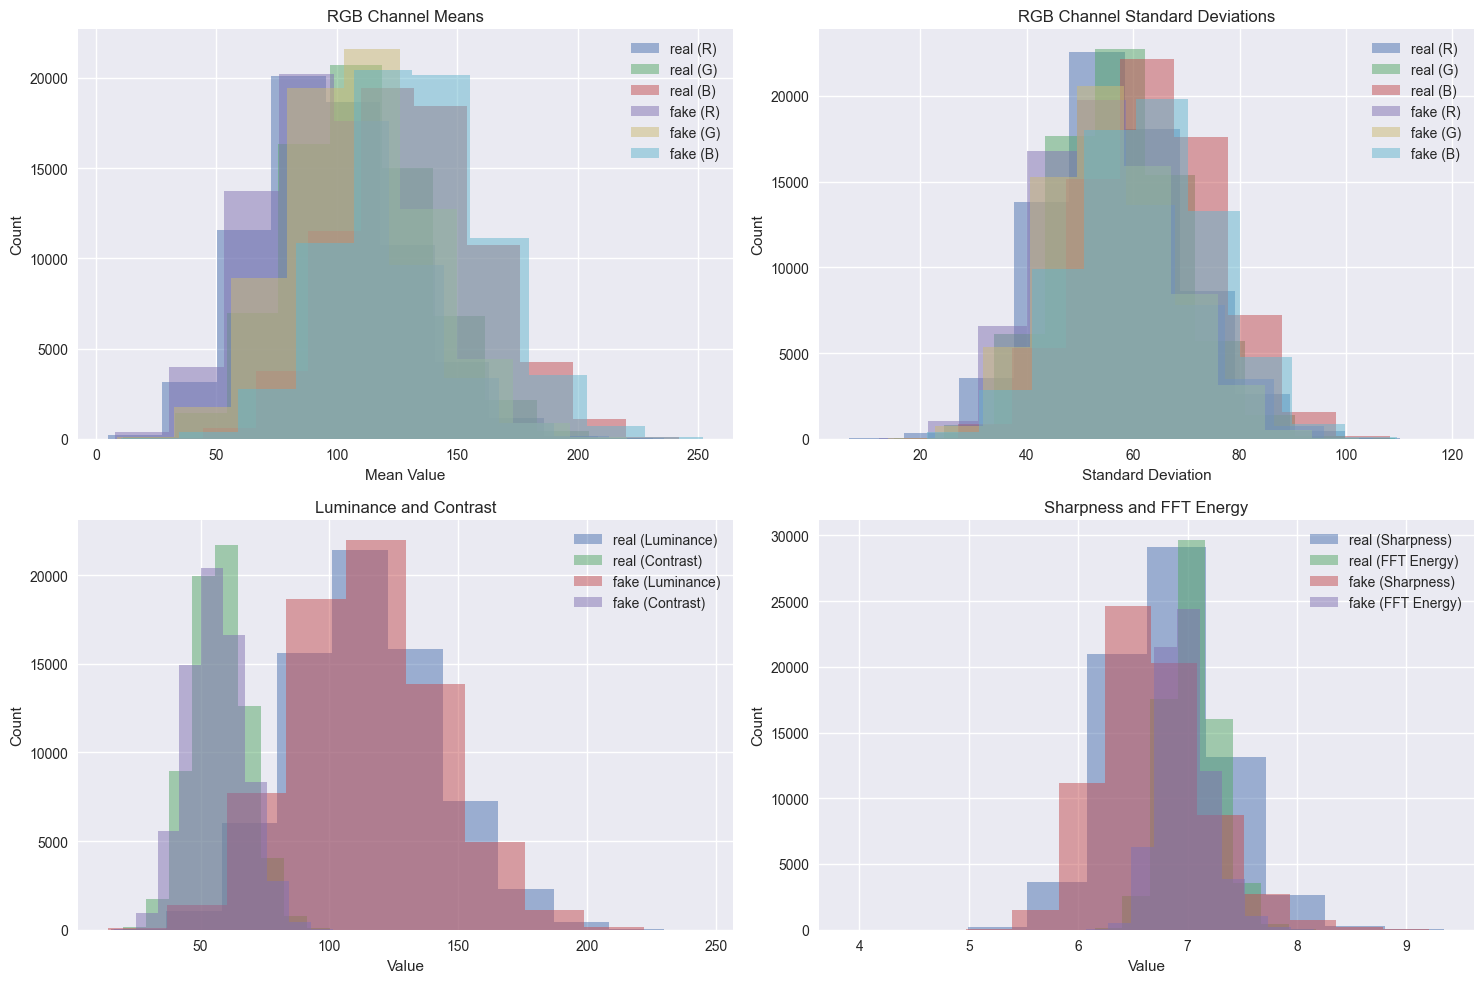

In [47]:

# Index files
rows = []
for split in ("train", "valid", "test"):
    for label in ("real", "fake"):
        for fp in (DATA_DIR/split/label).glob("*"):
            rows.append({"path": fp, "split": split, "label": label})
df = pd.DataFrame(rows)

# Extract features
stats = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing"):
    img = cv2.imread(str(row.path))
    h, w = img.shape[:2]
    img_small = cv2.resize(img, (0,0), fx=IMG_SIZE/min(h,w), fy=IMG_SIZE/min(h,w))
    
    # RGB stats
    mean = img_small.mean(axis=(0,1))
    std = img_small.std(axis=(0,1))
    
    # Luminance & contrast
    yuv = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
    lum = yuv[...,0].mean()
    cont = yuv[...,0].std()
    
    # Sharpness (with log)
    gray = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)
    sharp = np.log(cv2.Laplacian(gray, cv2.CV_64F).var() + 1)
    
    # FFT energy
    f = np.fft.fftshift(np.fft.fft2(gray))
    fftE = np.log(np.abs(f)+1).mean()
    
    stats.append([row.split,row.label,w,h,*mean,*std,lum,cont,sharp,fftE])

# Create dataframe
cols = ["split","label","width","height",
        "r_mean","g_mean","b_mean","r_std","g_std","b_std",
        "lum","contrast","sharp","fft_energy"]
stat_df = pd.DataFrame(stats, columns=cols)

# Print descriptive statistics
print("\nClass Balance:")
print(df.groupby(["split","label"]).size().unstack())

print("\nResolution Statistics:")
print(stat_df.groupby("label")[["width", "height"]].describe())

print("\nRGB Channel Statistics:")
rgb_cols = ["r_mean", "g_mean", "b_mean", "r_std", "g_std", "b_std"]
print(stat_df.groupby("label")[rgb_cols].describe())

print("\nImage Quality Statistics:")
quality_cols = ["lum", "contrast", "sharp", "fft_energy"]
print(stat_df.groupby("label")[quality_cols].describe())

# Plot histograms for key features
plt.figure(figsize=(15, 10))

# RGB means
plt.subplot(2, 2, 1)
for label in ["real", "fake"]:
    data = stat_df[stat_df["label"] == label]
    plt.hist(data["r_mean"], alpha=0.5, label=f"{label} (R)")
    plt.hist(data["g_mean"], alpha=0.5, label=f"{label} (G)")
    plt.hist(data["b_mean"], alpha=0.5, label=f"{label} (B)")
plt.title("RGB Channel Means")
plt.xlabel("Mean Value")
plt.ylabel("Count")
plt.legend()

# RGB standard deviations
plt.subplot(2, 2, 2)
for label in ["real", "fake"]:
    data = stat_df[stat_df["label"] == label]
    plt.hist(data["r_std"], alpha=0.5, label=f"{label} (R)")
    plt.hist(data["g_std"], alpha=0.5, label=f"{label} (G)")
    plt.hist(data["b_std"], alpha=0.5, label=f"{label} (B)")
plt.title("RGB Channel Standard Deviations")
plt.xlabel("Standard Deviation")
plt.ylabel("Count")
plt.legend()

# Image quality metrics
plt.subplot(2, 2, 3)
for label in ["real", "fake"]:
    data = stat_df[stat_df["label"] == label]
    plt.hist(data["lum"], alpha=0.5, label=f"{label} (Luminance)")
    plt.hist(data["contrast"], alpha=0.5, label=f"{label} (Contrast)")
plt.title("Luminance and Contrast")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()

# Sharpness and FFT energy
plt.subplot(2, 2, 4)
for label in ["real", "fake"]:
    data = stat_df[stat_df["label"] == label]
    plt.hist(data["sharp"], alpha=0.5, label=f"{label} (Sharpness)")
    plt.hist(data["fft_energy"], alpha=0.5, label=f"{label} (FFT Energy)")
plt.title("Sharpness and FFT Energy")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ──────────────── AUGMENTATION ────────────────
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

# ──────────────── MODEL ────────────────
inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = layers.Rescaling(1/255.)(inputs)
x = augment(x)

for filters in (32, 64, 128):
    x = layers.Conv2D(filters, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)  # keep FP32 out

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)
model.summary()

# ──────────────── CALLBACKS ────────────────
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "best_fake_real.keras", save_best_only=True, monitor="val_loss"
)
es   = tf.keras.callbacks.EarlyStopping(
    patience=4, restore_best_weights=True, monitor="val_loss"
)

# ──────────────── TRAIN ────────────────
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[ckpt, es],
)

# ──────────────── FREE MEMORY & RELOAD BEST MODEL ────────────────
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("best_fake_real.keras")

# ──────────────── TEST EVALUATION ────────────────
loss, acc, prec, rec = model.evaluate(test_ds, verbose=0)
print(f"\nTEST  acc={acc:.3f}  precision={prec:.3f}  recall={rec:.3f}")

# ──────────────── OPTIONAL PREDICTIONS ────────────────
# import numpy as np
# probs = model.predict(test_ds.take(1))
# print("First 10 probabilities:", np.round(probs[:10].ravel(), 3))








Found 100000 files belonging to 2 classes.


2025-05-26 21:11:53.749703: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-26 21:11:53.749731: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-05-26 21:11:53.749738: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-05-26 21:11:53.749755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 21:11:53.749767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,921 (20.61 MB)

 Trainable params: 5,401,921 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2025-05-26 21:11:55.300178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 80ms/step - accuracy: 0.6549 - loss: 0.6145 - precision: 0.6521 - recall: 0.6724 - val_accuracy: 0.7474 - val_loss: 0.5036 - val_precision: 0.8328 - val_recall: 0.6192
Epoch 2/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 236s 75ms/step - accuracy: 0.7698 - loss: 0.4824 - precision: 0.7684 - recall: 0.7681 - val_accuracy: 0.8140 - val_loss: 0.4163 - val_precision: 0.8331 - val_recall: 0.7854
Epoch 3/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 240s 77ms/step - accuracy: 0.8057 - loss: 0.4252 - precision: 0.8062 - recall: 0.8053 - val_accuracy: 0.8378 - val_loss: 0.3676 - val_precision: 0.8716 - val_recall: 0.7922
Epoch 4/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 258s 83ms/step - accuracy: 0.8340 - loss: 0.3785 - precision: 0.8343 - recall: 0.8331 - val_accuracy: 0.8601 - val_loss: 0.3365 - val_precision: 0.8425 - val_recall: 0.8856
Epoch 5/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 236s 76ms/step - accuracy: 0.8518 - loss: 0.3461 - precision: 0.8501 - recall: 0.8530 - val_accuracy: 0.8792 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



TEST  acc=0.964  precision=0.964  recall=0.965


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


  7/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step  

2025-05-30 18:15:37.339830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


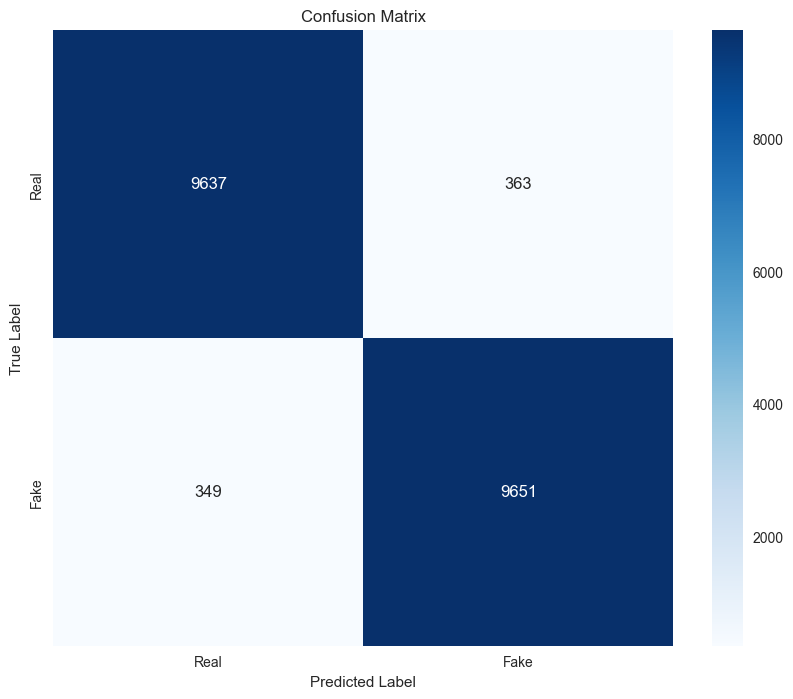


Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.96      0.96     10000
        Fake       0.96      0.97      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



In [10]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the best model
model = tf.keras.models.load_model("best_fake_real.keras")

# Get predictions on test set
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = (model.predict(test_ds).ravel() > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
